# Convolutional Neural Networks (CNNs)

**Product photo quality triage & category classification**

- Uses **synthetic data** with the same schema so it runs anywhere
- Classify dark and occlude images

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt, warnings
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import ipyplot
np.random.seed(42)
random.seed(42)
warnings.filterwarnings("ignore")

## 1) Synthetic images & labels

Images: (800, 96, 96) Labels: (800,)



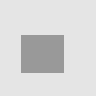
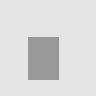
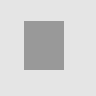
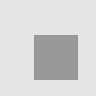
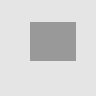


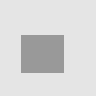
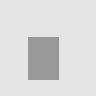
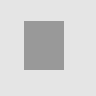
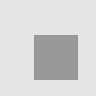
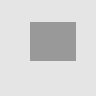

<Okay images>



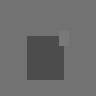
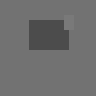
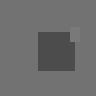
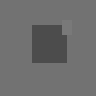
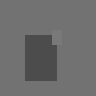


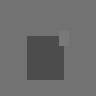
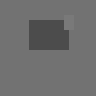
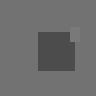
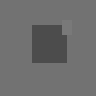
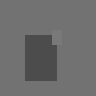

<Reject images>


In [2]:
# Build simple synthetic grayscale images with rectangles (as 'products') and noise to simulate quality

def motion_blur(img, k=9, angle=0):
    # Create motion kernel
    kernel = np.zeros((k, k))
    kernel[int((k-1)/2), :] = np.ones(k)
    M = cv2.getRotationMatrix2D((k/2 -0.5 , k/2 -0.5), angle, 1)
    kernel = cv2.warpAffine(kernel, M, (k, k))
    kernel /= kernel.sum()
    return cv2.filter2D(img, -1, kernel)

rng = np.random.default_rng(42)
def synth_image(N=96, blur=False, dark=False, occlude=False):
    img = np.ones((N,N))*0.9
    x0,y0 = rng.integers(20,40), rng.integers(20,40)
    x1,y1 = x0 + rng.integers(30,50), y0 + rng.integers(30,50)
    img[y0:y1, x0:x1] = 0.6
    if occlude:
        img[y0-5:y0+10, x1-5:x1+5] = 0.95
    if dark:
        img *= 0.5
    return img

X, y = [], []
for _ in range(600):
    X.append(synth_image())
    y.append(0)  # OK
for _ in range(200):
    X.append(synth_image(dark=True, occlude=True))
    y.append(1)  # Reject
X = np.stack(X); y = np.array(y)
print("Images:", X.shape, "Labels:", y.shape)

ipyplot.plot_images(X[:600], max_images=5, img_width=200)
print("<Okay images>")
ipyplot.plot_images(X[601:], max_images=5, img_width=200)
print("<Reject images>")

idx = np.random.permutation(len(X)); X, y = X[idx], y[idx]

## 2) Lightweight baseline without deep libs (flatten + logistic for 3‑way)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 96, 96, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_last (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,426 (91.51 KB)

 Trainable params: 23,426 (91.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7188 - loss: 0.5595 - val_accuracy: 0.7500 - val_loss: 0.4365
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7500 - loss: 0.4450 - val_accuracy: 0.7500 - val_loss: 0.4280
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7500 - loss: 0.4282 - val_accuracy: 0.7500 - val_loss: 0.4154
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7500 - loss: 0.4114 - val_accuracy: 0.7500 - val_loss: 0.3946
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7500 - loss: 0.3836 - val_accuracy: 0.7500 - val_loss: 0.3641
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7500 - loss: 0.3475 - val_accuracy: 0.7500 - val_loss: 0.3154
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7500 - loss: 0.2877 - val_accuracy: 0.7500 - val_loss: 0.2394
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9109 - loss: 0.2012 - val_accuracy: 1.0000 - val_loss:

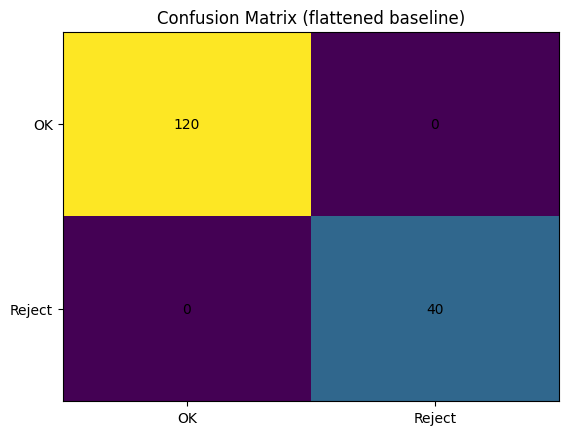

In [3]:
# CNN model
# 1Prepare data
X_img = X.astype("float32")
X_img = np.expand_dims(X_img, axis=-1)
num_classes = int(np.max(y)) + 1

X_tr_i, X_val_i, y_tr_i, y_val_i = train_test_split(
    X_img, y, test_size=0.2, stratify=y, random_state=42
)

# Build a small CNN; name the last conv layer for Grad-CAM
def build_cnn(input_shape=(96,96,1), num_classes=3):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, padding="same", activation="relu", name="conv1")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu", name="conv2")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu", name="conv_last")(x)  # last conv
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_cnn((96,96,1), num_classes)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Light train (increase epochs for better perf)
history = model.fit(X_tr_i, y_tr_i, validation_data=(X_val_i, y_val_i),
                    epochs=8, batch_size=64, verbose=1)

# Confusion matrix
pred = model.predict(X_val_i)
pred_class = np.argmax(pred, axis=1)
print(classification_report(y_val_i, pred_class, digits=2))
cm = confusion_matrix(y_val_i, pred_class, labels=[0,1])
plt.figure(); plt.imshow(cm, aspect="auto"); plt.title("Confusion Matrix (flattened baseline)")
plt.xticks([0,1], ["OK","Reject"]); plt.yticks([0,1], ["OK","Reject"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(cm[i,j]), ha="center", va="center")
plt.show()

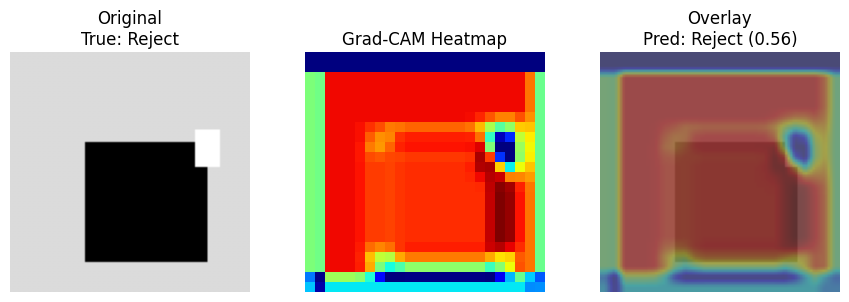

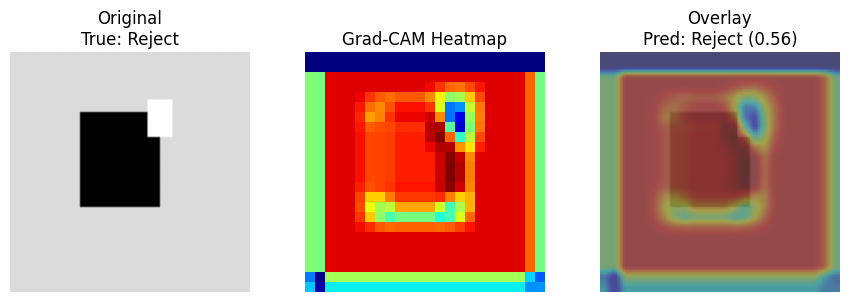

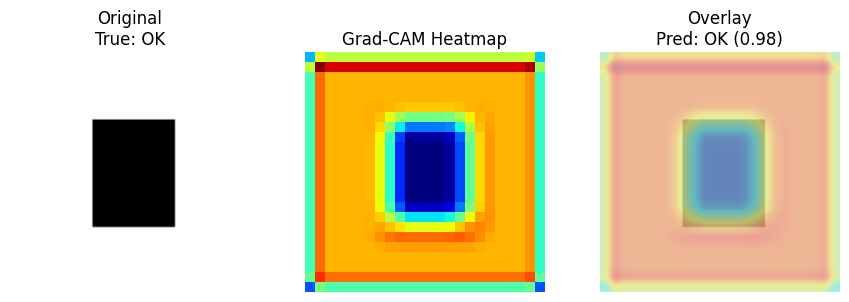

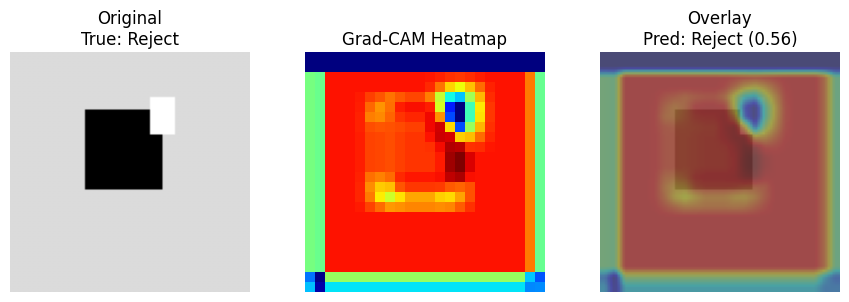

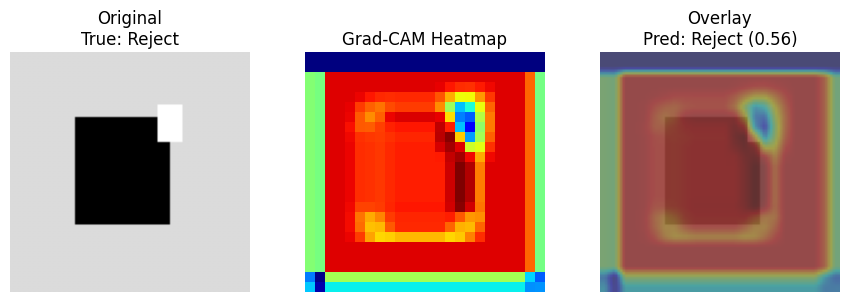

In [5]:
# Grad-CAM utilities (works for grayscale; overlay converts to RGB)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index=None):
    """
    img_array: (1, H, W, C) float tensor
    class_index: optional target class; otherwise uses predicted class
    """
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = keras.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_outputs)           # (1, Hc, Wc, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))         # (C,)
    conv_outputs = conv_outputs[0]                               # (Hc, Wc, C)
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img_gray, heatmap, alpha=0.35):
    """img_gray: (H,W,1) or (H,W). Produces RGB overlay."""
    import cv2
    if img_gray.ndim == 3 and img_gray.shape[-1] == 1:
        img_gray = img_gray[..., 0]
    # scale to 0..255 uint8 if needed
    if img_gray.dtype != np.uint8:
        img_disp = np.uint8(np.clip(img_gray * 255, 0, 255))
    else:
        img_disp = img_gray
    h, w = img_disp.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    img_rgb = np.stack([img_disp]*3, axis=-1)  # grayscale -> RGB
    overlay = np.uint8(np.clip(heatmap_color * alpha + img_rgb * (1 - alpha), 0, 255))
    return overlay

# Visualize Grad-CAM for a couple of validation images
class_names = {0: "OK", 1: "Reject"}
last_conv_layer_name = "conv_last"

rng = np.random.default_rng(0)
idxs = rng.choice(len(X_val_i), size=5, replace=False)
for idx in idxs:
    img = X_val_i[idx]
    lab = int(y_val_i[idx])
    img_batch = np.expand_dims(img, axis=0)

    pred = model.predict(img_batch, verbose=0)[0]
    pred_class = int(np.argmax(pred))
    confidence = float(np.max(pred))

    heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name, class_index=pred_class)
    overlay = overlay_heatmap_on_image(img, heatmap, alpha=0.35)

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img[...,0], cmap="gray"); plt.axis('off')
    plt.title(f"Original\nTrue: {class_names[lab]}")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis('off')
    plt.title(f"Overlay\nPred: {class_names[pred_class]} ({confidence:.2f})")
    plt.tight_layout(); plt.show()